# Basics of classification on the *Iris* dataset

First, let's import some packages. In particular, we will need `numpy` and `pandas` for processing the data, `pyplot` for making plots, and the implementations of the classification algorithms and basic evaluation metrics from `sklearn` (a.k.a. 'scikit-learn').

See the documentation:

   - numpy (https://numpy.org/doc/stable/)
   - pandas (https://pandas.pydata.org/pandas-docs/stable/index.html)
   - matplotlib.pyplot (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
   - sklearn.tree (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)
   - sklearn.svm (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
   - sklearn.metrics (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [35]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn import tree, svm, metrics

For repeatability, set the seed of the seudo-random number generator to some large integer of your choice. In particular, set the value of `SEED` in the first line below to your student number.

In [36]:
SEED = 2216929
RS = numpy.random.RandomState(numpy.random.MT19937(numpy.random.SeedSequence(SEED)))

## Loading and preparing the data

[Iris](https://archive.ics.uci.edu/ml/datasets/Iris) is one of the popular datasets from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php), and the main example dataset used in part II of the course.

The dataset contains physical measurements of iris flowers, as the predictive attributes, accompanied by the indication of the species each specimen belongs to, as the class. 

In particular, from the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names) we can find the list of attributes:

Name | unit | 
---- | ---- |
sepal length | cm |
sepal width  | cm |
petal length | cm |
petal width  | cm |
**class** | 'Iris-setosa', 'Iris-versicolor' or 'Iris-virginica'

The classification task we consider here is to predict the species of a flower specimen based on its physical measurements.

First, we read the data in and display an outline.

In [37]:
cnames = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Class']
dtf = pandas.read_csv('iris.data', sep=',', names=cnames) # LOCALLY
# dtf = pandas.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', sep=',', names=cnames) # REMOTELY
dtf

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


We define three colors for plotting the different classes.

In [38]:
class_colors = ['#DDAA33', '#BB5566', '#004488']

We separate the predictive attributes from the class attribute, putting them in numpy arrays.

In [39]:
natts = len(cnames)-1
X = numpy.vstack([dtf[c] for c in cnames[:-1]]).T
y = numpy.array(dtf[cnames[-1]].rank(method='dense', ascending=True).astype(int)-1)
classes = sorted(set(dtf[cnames[-1]]))
classes

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

Now we are ready to plot the data, showing scatter plots of all pairs of predictive attributes. 
Each dot represents a flower specimen with the color indicating the species. Some specimens have the same values for the attributes and hence the dots overlap.

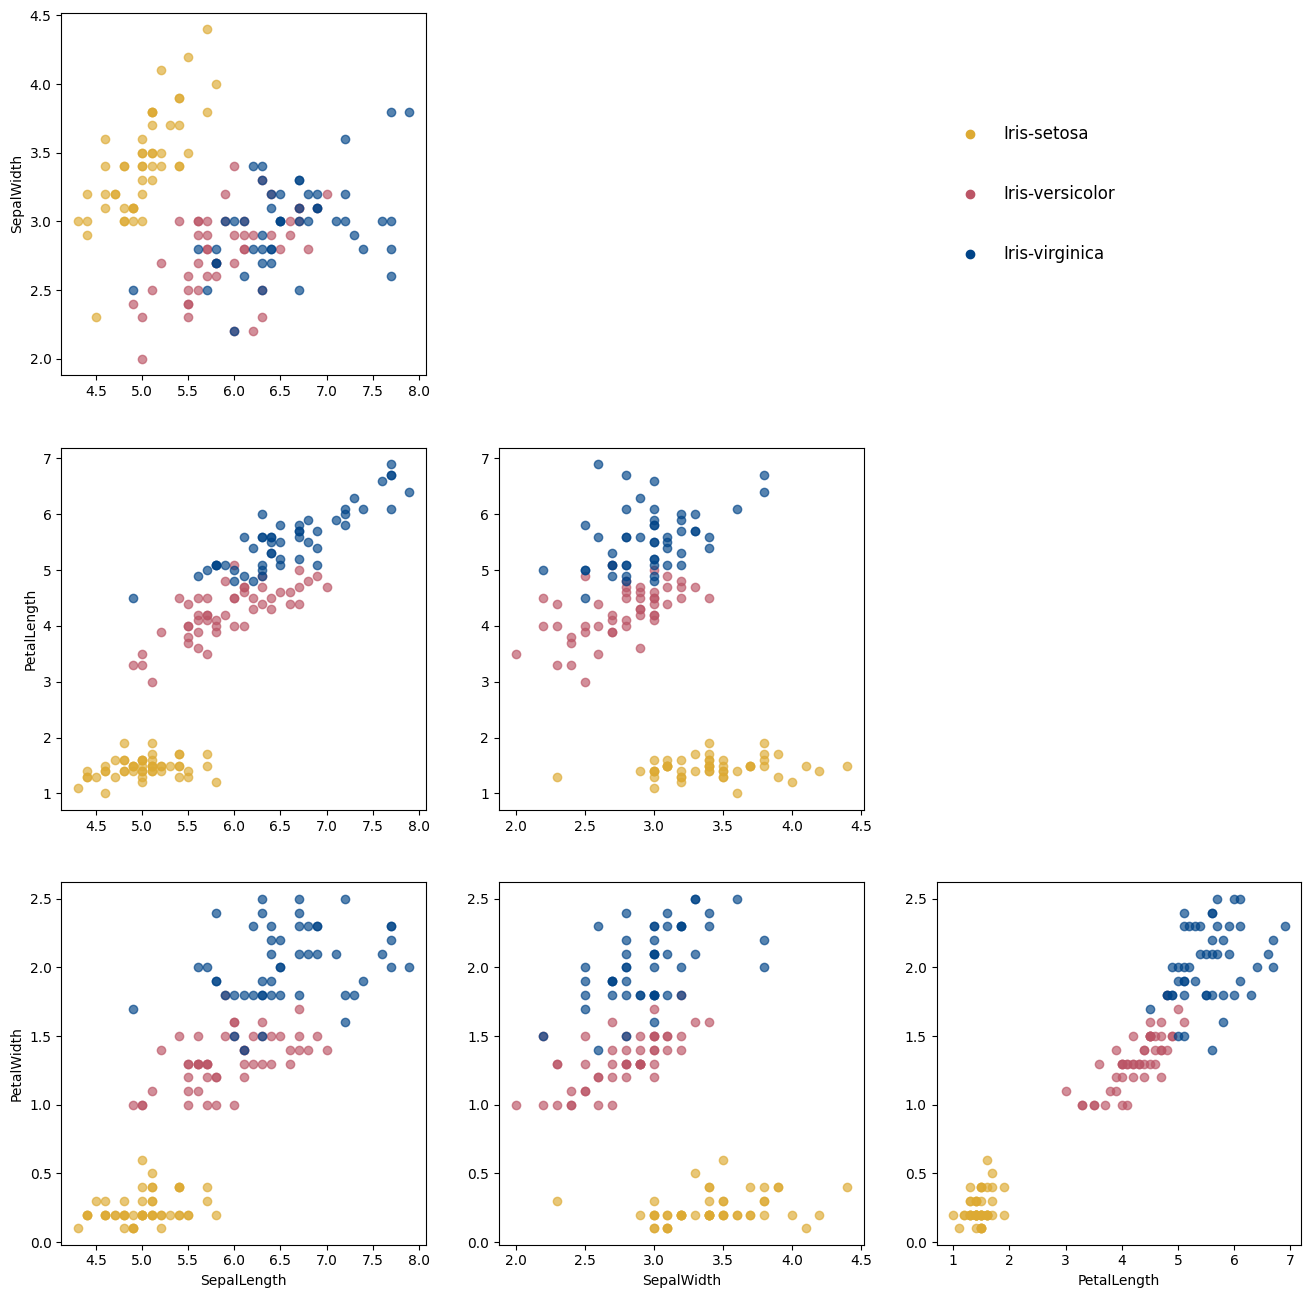

In [40]:
fig, axes = plt.subplots(natts-1, natts-1, figsize=(16,16))
for xi, xname in enumerate(cnames[:-1]):
    if xi > 0:
        axes[xi-1, 0].set_ylabel(xname)
    if xi < natts-1:
        axes[natts-2, xi].set_xlabel(xname)
    
    for yi, yname in enumerate(cnames[:xi]):
        for ci, cc in enumerate(classes):
            axes[xi-1, yi].plot(X[y==ci,yi], X[y==ci,xi], 'o', color=class_colors[ci], alpha=0.66)    
        if yi != xi-1:
            axes[yi, xi-1].axis('off')

for ci, cc in enumerate(classes):
    axes[0, -1].scatter([0], [ci], color=class_colors[ci], cmap='Accent', vmin=0, vmax=3)
    axes[0, -1].text(0.1, ci, cc, verticalalignment='center', fontsize=12)
axes[0, -1].set_xlim([-.1,1])
axes[0, -1].set_ylim([len(classes)+1,-2])
plt.show()

As evidenced by partially overlapping point clouds, versicolor and virginica species are rather similar, with the latter being slightly larger. The setosa species, on the other hand, is quite distinct.

## Binary classification 'Iris-setosa' vs. Iris-virginica' using a decision tree

We start with the simplest binary classification task, telling 'Iris-setosa' (class label 0, `y==0`) from Iris-virginica' (class label 2, `y==2`), using a decision trees.

First we prepare the data, splitting it into training and test subsets (in proportion 80%-20%).
We show the class labels of the test instances.

In [41]:
ratio_test = 0.2
idsC0 = numpy.random.permutation(numpy.where(y == 0)[0])
idsC2 = numpy.random.permutation(numpy.where(y == 2)[0])
nbC0_test = int(ratio_test * len(idsC0))
nbC2_test = int(ratio_test * len(idsC2))
ids02_test = numpy.concatenate((idsC0[:nbC0_test], idsC2[:nbC2_test]))
ids02_train = numpy.concatenate((idsC0[nbC0_test:], idsC2[nbC2_test:]))
X02_train = X[ids02_train, :]
y02_train = y[ids02_train]
X02_test = X[ids02_test, :]
y02_test = y[ids02_test]
y02_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We setup a [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with default parameters, fit it on the training subset, and generate the predictions for the test subset.

In [42]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X02_train, y02_train)
y02_pred_dt = dt.predict(X02_test)
y02_pred_dt

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task, i.e. the ratio of predicted class labels that match the ground truth.

In [43]:
metrics.accuracy_score(y02_test, y02_pred_dt)

1.0

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [44]:
metrics.precision_score(y02_test, y02_pred_dt, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [45]:
metrics.recall_score(y02_test, y02_pred_dt, pos_label=2)

1.0

An accuracy of 1.0 indicates a perfect classification, and implies also perfect recall and precision. We expect a good performance, as we saw from the plots that specimens from the two classes are rather distinct in the measurements.

Next, we show a diagram of the learnt decision tree.

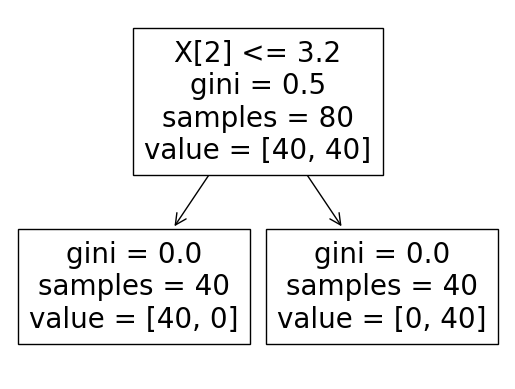

In [46]:
tree.plot_tree(dt)
plt.show()

We expect a simple tree, since no complex tests seem necessary to tell the two classes apart.


## Binary classification 'Iris-versicolor' vs. Iris-virginica' using decision trees

Next, we try another binary classification task, telling 'Iris-versicolor' (class label 1, `y==1`) from Iris-virginica' (class label 2, `y==2`), using decision trees.

We prepare the data, splitting it into training and test subsets (in proportion 80%-20%).
We show the class labels of the test instances.

In [47]:
ratio_test = 0.2
idsC1 = numpy.random.permutation(numpy.where(y == 1)[0])
idsC2 = numpy.random.permutation(numpy.where(y == 2)[0])
nbC1_test = int(ratio_test * len(idsC1))
nbC2_test = int(ratio_test * len(idsC2))
ids12_test = numpy.concatenate((idsC1[:nbC1_test], idsC2[:nbC2_test]))
ids12_train = numpy.concatenate((idsC1[nbC1_test:], idsC2[nbC2_test:]))
X12_train = X[ids12_train, :]
y12_train = y[ids12_train]
X12_test = X[ids12_test, :]
y12_test = y[ids12_test]
y12_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We setup a decision tree classifier, with default parameters, fit it on the training subset, and generate the predictions for the test subset.

In [48]:
dtA = tree.DecisionTreeClassifier()
dtA = dtA.fit(X12_train, y12_train)
y12_pred_dtA = dtA.predict(X12_test)
y12_pred_dtA

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [49]:
metrics.accuracy_score(y12_test, y12_pred_dtA)

0.95

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [50]:
metrics.precision_score(y12_test, y12_pred_dtA, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [51]:
metrics.recall_score(y12_test, y12_pred_dtA, pos_label=2)

0.9

We show a diagram of the learnt decision tree.

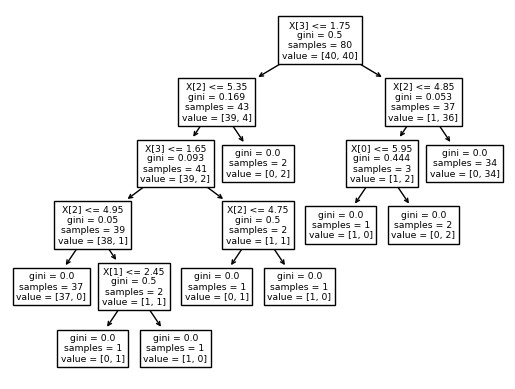

In [52]:
tree.plot_tree(dtA)
plt.show()

We expect the performance to be somewhat worse and the decision tree more complex than in the previous task, since the two classes are more similar.

Next, we train another decision tree for the same task, with the same train/test split, but using entropy as the split criterion instead of the default gini (`criterion`).

In [53]:
dtB = tree.DecisionTreeClassifier(criterion='entropy')
dtB = dtB.fit(X12_train, y12_train)
y12_pred_dtB = dtB.predict(X12_test)
y12_pred_dtB

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [54]:
metrics.accuracy_score(y12_test, y12_pred_dtB)

0.95

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [55]:
metrics.precision_score(y12_test, y12_pred_dtB, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [56]:
metrics.recall_score(y12_test, y12_pred_dtB, pos_label=2)

0.9

We show a diagram of the learnt decision tree.

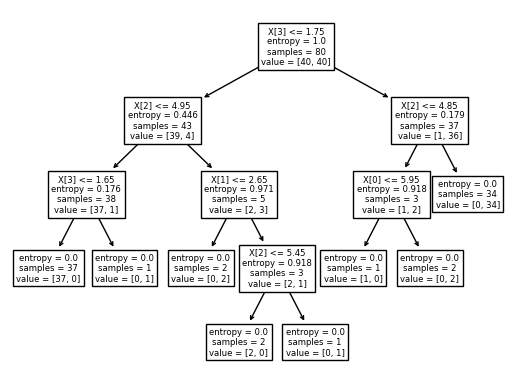

In [57]:
tree.plot_tree(dtB)
plt.show()

Finally, we train yet another decision tree for the same task, with the same train/test split, again using entropy, but raising the minimum number of samples required to split an internal node (`min_samples_split`) from the default value of 2 to 10.

In [58]:
dtC = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dtC = dtC.fit(X12_train, y12_train)
y12_pred_dtC = dtC.predict(X12_test)
y12_pred_dtC

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [59]:
metrics.accuracy_score(y12_test, y12_pred_dtC)

1.0

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [60]:
metrics.precision_score(y12_test, y12_pred_dtC, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [61]:
metrics.recall_score(y12_test, y12_pred_dtC, pos_label=2)

1.0

We show a diagram of the learnt decision tree.

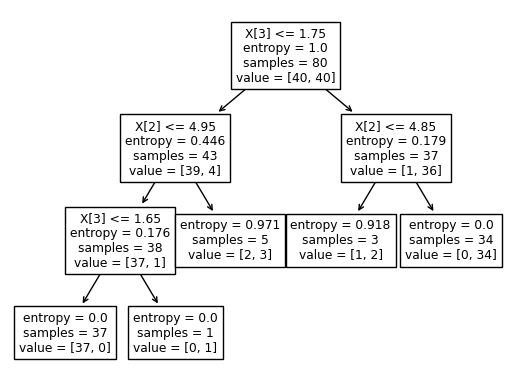

In [62]:
tree.plot_tree(dtC)
plt.show()

As a consequence of raising `min_samples_split` the complexity of the resulting decision is reduced, which might help tackle over-fitting.  

## Ternary classification using a decision tree

Decision trees are able to handle more than two classes, i.e. are not limited to binary classification.
Next, we learn a decision tree to tell the three species apart directly.

We prepare the data, splitting it into training and test subsets (in proportion 80%-20%).
We show the class labels of the test instances.

In [63]:
ratio_test = 0.2
idsC0 = numpy.random.permutation(numpy.where(y == 0)[0])
idsC1 = numpy.random.permutation(numpy.where(y == 1)[0])
idsC2 = numpy.random.permutation(numpy.where(y == 2)[0])
nbC0_test = int(ratio_test * len(idsC0))
nbC1_test = int(ratio_test * len(idsC1))
nbC2_test = int(ratio_test * len(idsC2))
ids012_test = numpy.concatenate((idsC0[:nbC0_test], idsC1[:nbC1_test], idsC2[:nbC2_test]))
ids012_train = numpy.concatenate((idsC0[nbC0_test:], idsC1[nbC1_test:], idsC2[nbC2_test:]))
X012_train = X[ids012_train, :]
y012_train = y[ids012_train]
X012_test = X[ids012_test, :]
y012_test = y[ids012_test]
y012_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

We train a decision tree for this ternary task, with the parameters as previously.

In [64]:
dtT = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dtT = dtT.fit(X012_train, y012_train)
y012_pred_dtT = dtT.predict(X012_test)
y012_pred_dtT

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [90]:
metrics.accuracy_score(y012_test, y012_pred_dtT)

0.9666666666666667

Precision and recall are not really meaningful and useful in the ternary case.

We show a diagram of the learnt decision tree. Note that the distribution in the leaves is over three values, corresponding to the three classes, instead of just two previously.

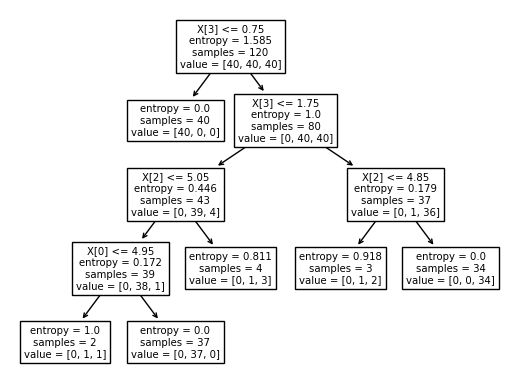

In [66]:
tree.plot_tree(dtT)
plt.show()

## Binary classification 'Iris-setosa' vs. Iris-virginica' using a support vector machine (SVM)

We go back to the first binary classification task, telling 'Iris-setosa' from Iris-virginica', this time using a support vector machine. We use the data split prepared earlier.

We setup a [linear support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) with default parameters, fit it on the training subset, and generate the predictions for the test subset.

In [67]:
sv = svm.LinearSVC()
sv = sv.fit(X02_train, y02_train)
y02_pred_sv = sv.predict(X02_test)
y02_pred_sv

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [68]:
metrics.accuracy_score(y02_test, y02_pred_sv)

1.0

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [69]:
metrics.precision_score(y02_test, y02_pred_sv, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [70]:
metrics.recall_score(y02_test, y02_pred_sv, pos_label=2)

1.0

The two classes are easily separable, so we expect perfect accuracy, recall and precision.

## Binary classification 'Iris-versicolor' vs. Iris-virginica' using a support vector machine (SVM)

Next, we apply the same type of SVM to the 'Iris-versicolor' vs. Iris-virginica' task.

In [71]:
svA = svm.SVC(kernel='linear')
svA = svA.fit(X12_train, y12_train)
y12_pred_svA = svA.predict(X12_test)
y12_pred_svA

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [72]:
metrics.accuracy_score(y12_test, y12_pred_svA)

1.0

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [73]:
metrics.precision_score(y12_test, y12_pred_svA, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [74]:
metrics.recall_score(y12_test, y12_pred_svA, pos_label=2)

1.0

The two classes are not as clearly separable, so the accuracy can be somewhat lower.

Next, we try with a polynomial kernel of degree 3.

In [75]:
svB = svm.SVC(kernel='poly', degree=3)
svB = svB.fit(X12_train, y12_train)
y12_pred_svB = svB.predict(X12_test)
y12_pred_svB

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [76]:
metrics.accuracy_score(y12_test, y12_pred_svB)

1.0

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [77]:
metrics.precision_score(y12_test, y12_pred_svB, pos_label=2)

1.0

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [78]:
metrics.recall_score(y12_test, y12_pred_svB, pos_label=2)

1.0

Using a kernel SVM is useful when the classes cannot be separated with a simple hyperplane, but resorting to an complex decision boundary can be detrimental and lead to overfitting.

Finally, we train a linear SVM, but in two dimensions rather than four, i.e. only on attributes 'sepal width' and 'petal length'.

In [79]:
svC = svm.SVC(kernel='linear')
svC = svC.fit(X12_train[:,[1,2]], y12_train)
y12_pred_svC = svC.predict(X12_test[:,[1,2]])
y12_pred_svC

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We compute the accuracy of the classifier on this task.

In [80]:
metrics.accuracy_score(y12_test, y12_pred_svC)

0.95

We compute the precision, considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [81]:
metrics.precision_score(y12_test, y12_pred_svC, pos_label=2)

0.9090909090909091

And the recall, again considering 'Iris-virginica' as the positive class (`pos_label=2`).

In [82]:
metrics.recall_score(y12_test, y12_pred_svC, pos_label=2)

1.0

Since we are using only two dimensions, we can plot the data used in the task. Training instances are depicted as small squares, whereas test instances are depicted as larger circles, with the inner part colored according to the ground-truth class and the outer part according to the predicted class.
In other words, missclassified instances appear as circles with different color inside and out.

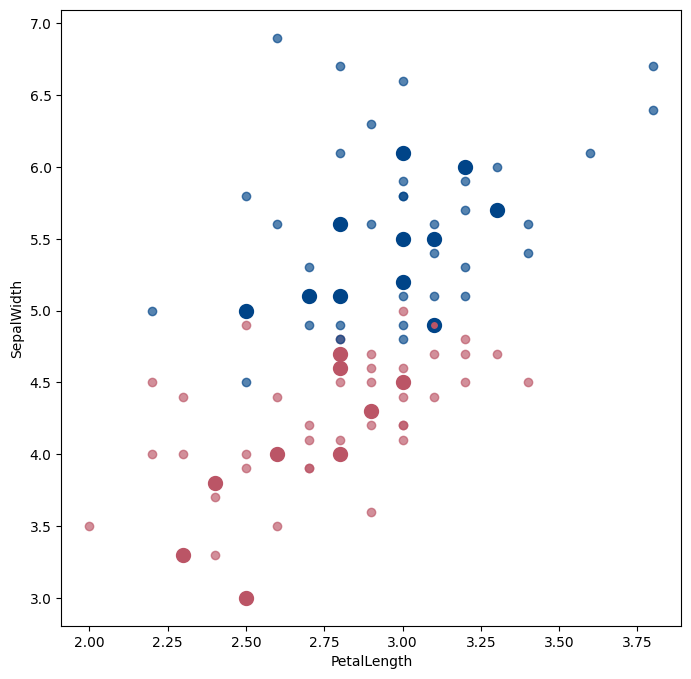

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(8,8))
for ci, cc in enumerate(classes):
    plt.plot(X12_train[y12_train==ci,1], X12_train[y12_train==ci,2], 
             '.', markersize=12, color=class_colors[ci], alpha=0.66)
for i, x in enumerate(X12_test):
    plt.plot(x[1], x[2], 'o', markersize=8, markeredgewidth=3,
             markerfacecolor=class_colors[y12_test[i]], markeredgecolor=class_colors[y12_pred_svC[i]])
plt.ylabel(cnames[1])
plt.xlabel(cnames[2])
plt.show()

Note that SVM are only able to handle binary problems, if more than two classes are involved further strategies are involved to combine binary classifiers. 

In this notebook we have seen how to apply two types of classifiers from the `sklearn` libraries, namely decision trees and support vector machines, on the 'iris' toy dataset.

[... add your observations here and throughout, as relevant]

# Observations

I expected lower evaluation scores for the decision trees and SVMs on the `Iris-versicolor vs Iris-virginica`, as they have overlapping point clouds.

Now, it would be interesting to evaluate the results on a multi-class SVM. Let's start with scikit SVC one-versus-one strategy. We train 4 classifiers with different kernels:

In [84]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X012_train, y012_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X012_train, y012_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X012_train, y012_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X012_train, y012_train)

And then make predictions on our test set:

In [85]:
linear_pred = linear.predict(X012_test)
poly_pred = poly.predict(X012_test)
rbf_pred = rbf.predict(X012_test)
sig_pred = sig.predict(X012_test)

Evaluating the accuracy:

In [86]:
accuracy_lin = metrics.accuracy_score(y012_test, linear_pred)
accuracy_poly = metrics.accuracy_score(y012_test, poly_pred)
accuracy_rbf = metrics.accuracy_score(y012_test, rbf_pred)
accuracy_sig = metrics.accuracy_score(y012_test, sig_pred)

'lin', accuracy_lin, 'poly', accuracy_poly, 'rbf', accuracy_rbf,'sig', accuracy_sig

('lin', 1.0, 'poly', 1.0, 'rbf', 1.0, 'sig', 0.03333333333333333)

The 'sigmoid' kernel got surprisingly low score for its accuracy, while both `lin` and `rbf` got a `1.0`.

We can now check the confusion matrixes for each kernel.

In [87]:
cm_lin = metrics.confusion_matrix(y012_test, linear_pred)
cm_poly = metrics.confusion_matrix(y012_test, poly_pred)
cm_rbf = metrics.confusion_matrix(y012_test, rbf_pred)
cm_sig = metrics.confusion_matrix(y012_test, sig_pred)

'lin', cm_lin, 'poly', cm_poly, 'rbf', cm_rbf,'sig', cm_sig

('lin',
 array([[10,  0,  0],
        [ 0, 10,  0],
        [ 0,  0, 10]], dtype=int64),
 'poly',
 array([[10,  0,  0],
        [ 0, 10,  0],
        [ 0,  0, 10]], dtype=int64),
 'rbf',
 array([[10,  0,  0],
        [ 0, 10,  0],
        [ 0,  0, 10]], dtype=int64),
 'sig',
 array([[ 1,  0,  9],
        [ 7,  0,  3],
        [10,  0,  0]], dtype=int64))

And here it becomes clear how the `sigmoid` kernel performed poorly. In comparison, the `poly` kernel got only `1 misclassificaiton`. We can also compare these with the two binary classifications using SVM done previously.

In [88]:
cm_svm_setosa_virginica = metrics.confusion_matrix(y02_test, y02_pred_sv)
cm_svm_versicolor_virginica = metrics.confusion_matrix(y02_test, y02_pred_sv)

'setosaXvirginica', cm_svm_setosa_virginica, 'versicolorXvirginica', cm_svm_versicolor_virginica

('setosaXvirginica',
 array([[10,  0],
        [ 0, 10]], dtype=int64),
 'versicolorXvirginica',
 array([[10,  0],
        [ 0, 10]], dtype=int64))

Both have only true positives and negatives.

I then tried to plot the classifiers in a similar way to what is seen in https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html, but I couldn't figure out this error.

ValueError: X has 2 features, but SVC is expecting 4 features as input.

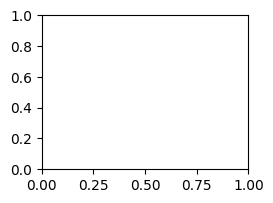

In [89]:
#stepsize in the mesh, it alters the accuracy of the plotprint
h = .01

#create the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),numpy.arange(y_min, y_max, h))

# create the title that will be shown on the plot
titles = ['Linear kernel','RBF kernel','Polynomial kernel','Sigmoid kernel']

for i, clf in enumerate((linear, rbf, poly, sig)):
    #defines how many plots: 2 rows, 2columns=> leading to 4 plots
    plt.subplot(2, 2, i + 1) #i+1 is the index

    #space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn, alpha=0.7)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.PuBuGn,     edgecolors='grey')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.show()

External resources: https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

No collaborations.